# House Price Prediction with Python (linear regression example)


## Purpose
In this task on House Price Prediction using machine learning, our task is to use data from the California census to create a machine learning model to predict house prices in the State. The data includes features such as population, median income, and median house prices for each block group in California.

Block groups are the smallest geographic unit which typically has a population of 600 to 3,000 people. We can call them districts for short. Ultimately, our machine learning model should learn from this data and be able to predict the median house price in any neighbourhood, given all other metrics.


# Setup

## Library import
We import all the required Python libraries

In [24]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt


# Data import
We retrieve all the required data for the analysis.

In [2]:
url = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv"
housing = pd.read_csv(url)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploratory Data Analysis
Simple EDA

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset. Total_bedrooms attribute has only 20,433 non-zero values, which means 207 districts do not contain values. We will have to deal with that later.

All attributes are numeric except for the ocean_proximity field. Its type is an object.

In [4]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Histogram for each numerical attribute:

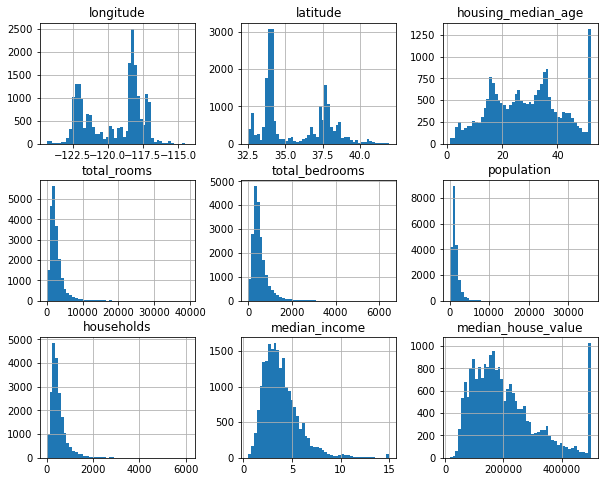

In [5]:
housing.hist(bins=50, figsize=(10, 8))
plt.show()

Let’s take a closer look at the histogram of median income, as most median income values cluster around 1.5 to 6, but some median income goes well beyond 6.

It is important to have a sufficient number of instances in your dataset for each stratum, otherwise, the estimate of the importance of a stratum may be biased. This means that you should not have too many strata and that each stratum should be large enough:

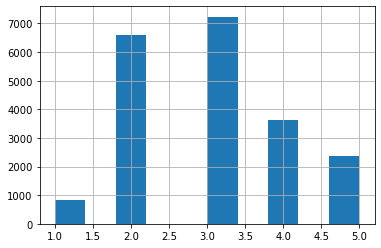

In [6]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()
plt.show()

# Stratified Sampling with Python

Now the next step is to perform stratified sampling based on income category. For this we will use the StratifiedShuffleSplit class of Scikit-Learn:

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(strat_test_set['income_cat'].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


Now remove the Income_cat attribute added to get the data back to its form and visualize the data in terms of longitude and latitude:

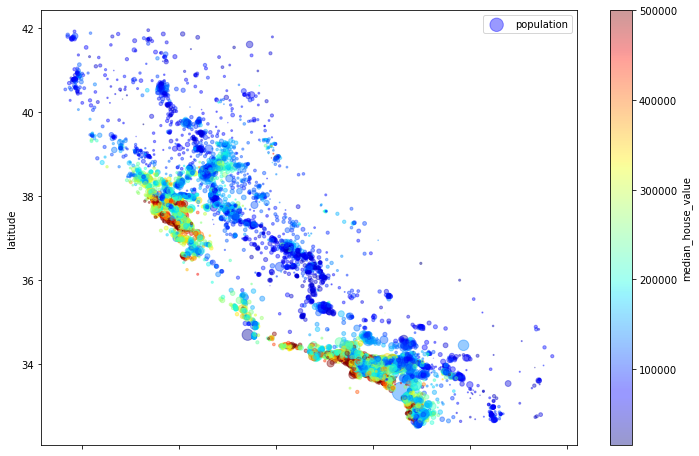

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
housing = strat_train_set.copy()
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population',
figsize=(12, 8), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

# Correlations
Since the dataset is not too large, you can easily calculate the standard correlation coefficient between each pair of attributes using the corr() method:

In [9]:
corr_matrix = housing.corr()
print(corr_matrix.median_house_value.sort_values(ascending=False))

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


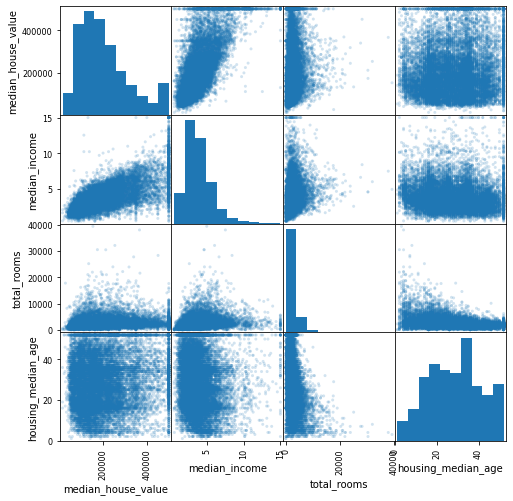

In [20]:
pd.plotting.scatter_matrix(housing.loc[:, ["median_house_value","median_income", "total_rooms", "housing_median_age"]], figsize=(8, 8), alpha=0.2);

Adding three new columns to the dataset; rooms per household, bedrooms per room and population per household and check the correlation again:

In [21]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


# Data processing
Now let’s perform all the necessary data transformations:

In [26]:

# Data Preparation
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

housing_num = housing.drop("ocean_proximity", axis=1)

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [27]:

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

# Linear Regression for House Price Prediction with Python

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

data = housing.iloc[:5]
labels = housing_labels.iloc[:5]
data_preparation = full_pipeline.transform(data)
print("Predictions: ", lin_reg.predict(data_preparation))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
